In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import torch.nn as nn 
import random
import torch
import torch.optim as optim 
from collections import deque,namedtuple
import warnings
from collections import OrderedDict
warnings.filterwarnings('ignore')#выключаем системные предупреждения

In [26]:
sity_num=650#городов в эпохе - переменная использовалась при тестировании
ep=15#кол-во эпох
#настройки сети
#коэф дисконтирования
dis_fuc = 0.99
#коэф обновления целевых параметров
TAU = 1e-4
#Снижение веса на L2
SN_WEIGHT = 1e-4
#learning rates
LR_CR = 5e-4
LR_AC = 1e-4 
MEM_SIZE = int(1e6)
forbidden_letters = ['ы']
#forbidden_letters=[]

In [3]:
data=pd.read_csv('cities.csv', encoding='cp1251')
data.head()

,Город,Страна,lat,lng,Население,Аб2,Аб3
0,Токио,Япония,35.6839,139.7744,39105000.0,JP,JPN
1,Джакарта,Индонезия,-6.2146,106.8451,35362000.0,ID,IDN
2,Дели,Индия,28.6667,77.2167,31870000.0,IN,IND
3,Манила,Филиппины,45091,120.9833,23971000.0,PH,PHL
4,Сан-Паулу,Бразилия,-23.5504,-46.6339,22495000.0,BR,BRA


In [5]:
data['Страна'].value_counts()

Соединенные Штаты                             7824
Бразилия                                      3604
Германия                                      2643
Италия                                        2140
Франция                                       2019
                                              ... 
Бермудские острова                               1
Западный берег                                   1
Северные Марианские острова                      1
Фолклендские острова (Мальвинские острова)       1
Виргинские острова США                           1
Name: Страна, Length: 238, dtype: int64

In [4]:
cites=pd.DataFrame(data['Город'].unique(),columns=['name'])
cites

,name
0,Токио
1,Джакарта
2,Дели
3,Манила
4,Сан-Паулу
...,...
38633,Тукчи
38634,Нумто
38635,Норд
38636,Тиммиармиут


In [10]:
cites=cites[cites.name.apply(lambda x: True if (re.fullmatch(r'[а-яА-ЯёЁ][а-яА-ЯёЁ\s\'-]+[а-яА-ЯёЁ]', str(x))) else False)]
cites

,name,first,last,active
0,Токио,т,о,True
1,Джакарта,д,а,True
2,Дели,д,и,True
3,Манила,м,а,True
4,Сан-Паулу,с,у,True
...,...,...,...,...
38633,Тукчи,т,и,True
38634,Нумто,н,о,True
38635,Норд,н,д,True
38636,Тиммиармиут,т,т,True


In [7]:
cites.isnull().sum()

name    0
dtype: int64

In [11]:
cites['first']=cites['name'].str[0].str.lower()
#for i in :
cites=cites[~cites['first'].isin(forbidden_letters)]

In [12]:

f_unique=cites['first'].unique()
print(f_unique)
cites['last']='0'#cites['name'].str[-1].str.lower()
cites['active']=True
#Ищем букву входящую в число букв с которых начинаются названия городов
def f(row, f_unique):
    i=-1
    lett=row['last']
    while True:
        if lett in f_unique:
            break
        else:
            lett=row['name'][i].lower()
            i-=1
    return lett


cites['last']=cites.apply(f, axis=1,f_unique=f_unique)
cites

['т' 'д' 'м' 'с' 'ш' 'г' 'к' 'п' 'н' 'б' 'е' 'л' 'х' 'р' 'ч' 'у' 'в' 'ф'
 'ц' 'а' 'я' 'ю' 'и' 'й' 'ж' 'о' 'э' 'з' 'щ']


,name,first,last,active
0,Токио,т,о,True
1,Джакарта,д,а,True
2,Дели,д,и,True
3,Манила,м,а,True
4,Сан-Паулу,с,у,True
...,...,...,...,...
38633,Тукчи,т,и,True
38634,Нумто,н,о,True
38635,Норд,н,д,True
38636,Тиммиармиут,т,т,True


In [13]:
stat=cites['name'].str[-1].str.lower()!=cites['last']
print(sum(stat))
cites[stat]

1320


,name,first,last,active
23,Шэньчжэнь,ш,н,True
35,Тяньцзинь,т,н,True
41,Ухань,у,н,True
49,Туншань,т,н,True
57,Дунгуань,д,н,True
...,...,...,...,...
38342,Дженерал Левалль,д,л,True
38373,Жэньчжуанцунь,ж,н,True
38378,Хэцзячуань,х,н,True
38536,Жалтырь,ж,р,True


In [14]:
cites[stat]['name'].str[-1].str.lower().value_counts()

ь    941
ы    376
ё      3
Name: name, dtype: int64

In [15]:
cites['first'].value_counts()

с    3711
к    3693
б    2901
м    2665
п    2166
а    1917
л    1786
т    1786
в    1745
д    1569
г    1474
н    1294
р    1166
х    1153
ф     824
о     822
и     812
э     763
у     674
ч     651
ш     549
з     441
ц     253
ю     206
я     198
е     101
ж      86
й      74
щ      10
Name: first, dtype: int64

In [16]:
cites[cites['first']=='ы']#Просто заинтересовал город на "ы"

,name,first,last,active


In [17]:
cites['transf']=cites['first']+cites['last']
stat=pd.merge(cites['last'].value_counts(), cites['first'].value_counts(), left_index=True, right_index=True).sort_index()
stat['last/first']=stat['last']/stat['first']
stat

,last,first,last/first
а,5778,1917,3.014085
б,114,2901,0.039297
в,278,1745,0.159312
г,1155,1474,0.783582
д,1015,1569,0.646909
е,1885,101,18.663366
ж,211,86,2.453488
з,256,441,0.580499
и,2867,812,3.530788
й,881,74,11.905405


Text(0.5, 1.0, 'Количество букв в начале и в конце')

<Figure size 1500x1200 with 0 Axes>

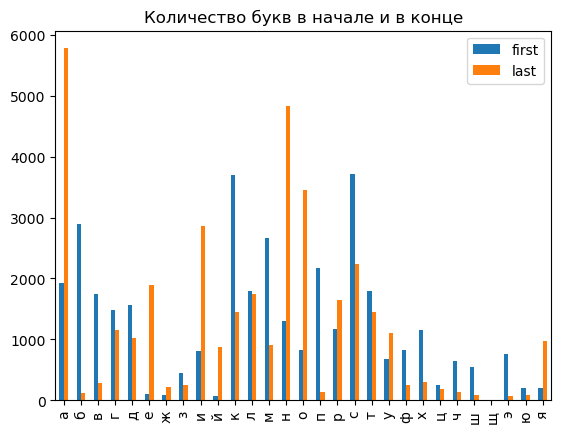

In [18]:
fig = plt.figure(figsize =(15, 12))
stat[['first','last']].plot.bar();
plt.title('Количество букв в начале и в конце')

Text(0.5, 1.0, 'Процентное разбиение первых букв')

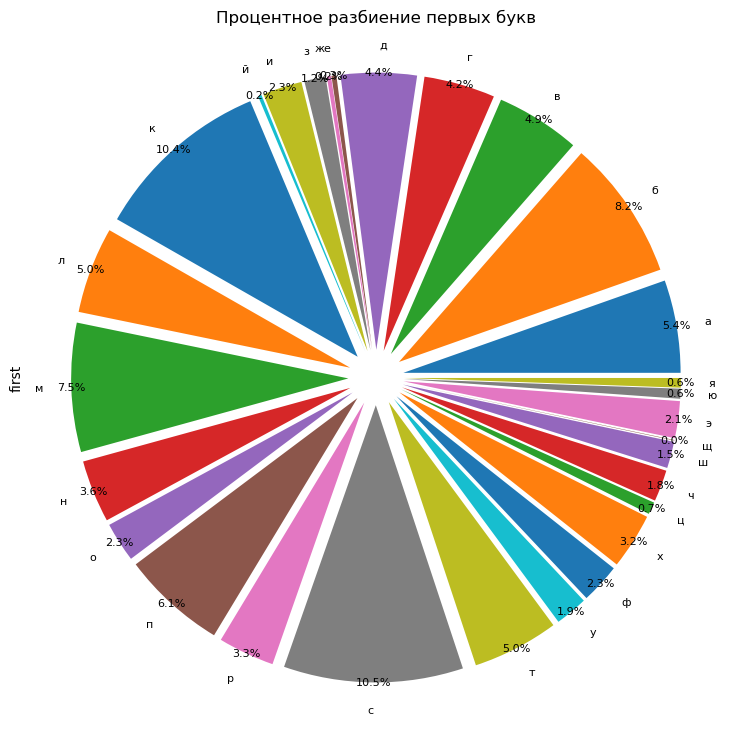

In [19]:
plt.figure(figsize =(12, 9))
stat['first'].plot.pie(autopct='%1.1f%%',pctdistance=1,explode=[0.1 for i in range (stat.shape[0])], textprops={'fontsize': 8});
plt.title('Процентное разбиение первых букв')

Text(0.5, 1.0, 'Процентное разбиение последних букв')

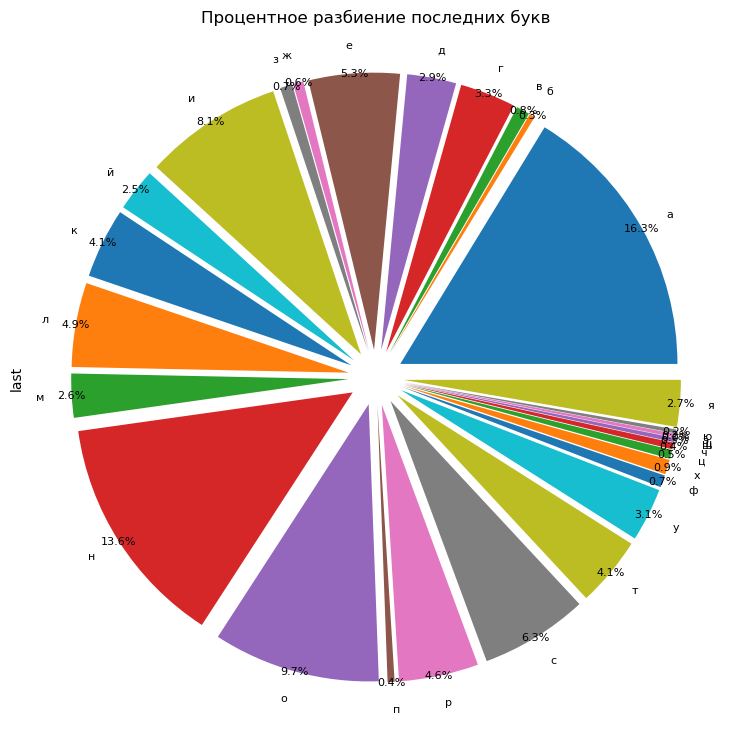

In [20]:
plt.figure(figsize =(12, 9))
stat['last'].plot.pie(autopct='%1.1f%%',pctdistance=1,explode=[0.1 for i in range (stat.shape[0])], textprops={'fontsize': 8});
plt.title('Процентное разбиение последних букв')

In [21]:
stat=pd.DataFrame((cites['transf']).value_counts().sort_index())
letters=stat.index

start_last=pd.DataFrame(stat.index,index=stat.index)#,columns=['transf'])

start_last['first']=start_last[0].str[0]
#'''
start_last['last']=start_last[0].str[1]
start_last=start_last.drop(0, axis=1)
#'''
for i in (['first','last']):
    k=start_last[i].unique()
    start_last=start_last.join(pd.get_dummies(start_last[i]))#.drop(i, axis=1)
    for ii in (k):
        start_last=start_last.rename(columns={ii: i+"_"+ii})
#'''
#start_last=start_last.drop('last', axis=1)
start_last#'''

,first,last,first_а,first_б,first_в,first_г,first_д,first_е,first_ж,first_з,...,last_у,last_ф,last_х,last_ц,last_ч,last_ш,last_щ,last_э,last_ю,last_я
аа,а,а,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
аб,а,б,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ав,а,в,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
аг,а,г,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ад,а,д,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
яф,я,ф,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
яц,я,ц,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
яэ,я,э,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
яю,я,ю,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [23]:
class Environment():
    def __init__(self, cites, start_last, apendd=False):
        #Последняя буква последнего названия города. False - любая (для начала игры) 
        self.prev_letter=False
        #Техническо-костыльное значение.
        self.cites=cites.append(pd.DataFrame({'name': ['Уже использован'], 'first': ['%'],'active':[False]}), ignore_index = True)
        self.apendd=apendd
        self.start_last=start_last
    def reset(self):
        self.cites['active']=self.cites["name"]!="Уже использован"
        self.prev_letter=False
    def cites_updet(self,cites):
        self.cites=cites.append(pd.DataFrame({'name': ['Уже использован'], 'first': ['%'],'active':[False]}), ignore_index = True)
    def step(self,city):
        done=False
        reward=-0.005#0.05
        inf=''
        if self.prev_letter==False or city[0].lower()==self.prev_letter:
            cit=self.cites[self.cites["name"] == city]
            if cit.shape[0]>0:
                if cit["active"].iloc[0]:
                    self.prev_letter=cit['last'].iloc[0]
                    self.cites["active"][self.cites["name"] == city]=False
                else:
                    done=True
                    reward=-100
                    inf='Повторное использование города'
                    print()
            elif self.apendd:
                self.cites.append(f(pd.DataFrame({'name': [city], 'first': [city[0].lower()], 'last': [city[-1]],'active':[False]}), f_unique), ignore_index = True)
                self.prev_letter=self.cites[self.cites["name"] == city]['last']
            else:
                done=True
                reward=-100
                inf='Введённое значение не является городом'
                print(inf)
        else:
            done=True
            reward=-100
            inf='Не правильная первая буква.'
            print(inf,'Город:',city,'Искомая буква',self.prev_letter)
        return(reward,done,inf)
    def stat(self):
        zam=100
        cit=pd.concat([self.start_last,self.cites[self.cites["active"]]['transf'].value_counts()], axis=1, join='outer')
        t=cit.groupby('first').sum()["transf"]
        t=pd.DataFrame({'lastt':t.index,'last_let_av':t.values})
        cit=cit.merge(t,left_on='last',right_on='lastt',how='outer')
        cit=cit.sort_values(by=['first','last'])
        cit=cit.drop('last', axis=1).drop('lastt', axis=1)
        if self.prev_letter:
            cit['first']=(cit['first']==self.prev_letter)*zam
        else:
            cit['first']=zam
        cit['transf']=(1-cit['transf']/cit['transf'].max())#*1.5#*10#1-
        #cit['transf']=cit['transf'].fillna(-zam)
        cit['no_city']=cit['transf'].isnull()*-zam
        cit['transf']=cit['transf'].fillna(0.5)#-zam)
        cit['last_let_av']=cit['last_let_av'].fillna(0)
        cit['last_let_av']=(1-cit['last_let_av']/cit['last_let_av'].max())/2#*1.5
        return cit
    def with_letter(self, letters):
        cit=self.cites[(self.cites["active"])&(self.cites["first"]==letters[0])&(self.cites["last"]==letters[1])]
        if cit.shape[0]>0:
            cit=cit.sample(n=1).name.values[0]
        else:
            cit="Уже использован"
        return cit

In [25]:
env=Environment(cites, start_last)
env.stat()#['last_let_av'].max()#[env.stat()['last_а']==1]

,first,first_а,first_б,first_в,first_г,first_д,first_е,first_ж,first_з,first_и,...,last_ц,last_ч,last_ш,last_щ,last_э,last_ю,last_я,transf,last_let_av,no_city
0,100,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.354037,0.241714,0
28,100,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.978261,0.109135,0
50,100,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.984472,0.264888,0
76,100,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.916149,0.301401,0
104,100,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.931677,0.288601,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.998447,0.388979,0
618,100,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0.998447,0.465912,0
682,100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0.995342,0.397198,0
705,100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0.996894,0.472245,0


In [27]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size, seed, hid_units=256):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, hid_units)
        #self.relu = nn.ReLU()# Ч
        self.drout = nn.Dropout(p=0.5, inplace=False)
        self.fc2 = nn.Linear(hid_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(0, 1e-4)

    def forward(self, state):
        #state = self.drout(self.relu(self.fc1(state)))
        state = self.drout((self.fc1(self.drout(state))))
        return nn.functional.tanh(self.fc2(state))

In [28]:
class MemoryCls:
    def __init__(self, action_size, mem_size, seed):
        self.mem_size=mem_size
        self.action_size = action_size
        self.memory = deque(maxlen=mem_size) 
        self.experience = namedtuple("Experience", field_names=["states", "action", "reward", "next_states", "done"])
        self.seed = random.seed(seed)
        
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        states = torch.from_numpy(np.vstack([e.states for e in self.memory if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in self.memory if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in self.memory if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_states for e in self.memory if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in self.memory if e is not None]).astype(np.uint8)).float().to(device)
        self.memory = deque(maxlen=self.mem_size)
        return (states, actions, rewards, next_states, dones)
    def __len__(self):
        return len(self.memory)



In [29]:
class Agent():
    def __init__(self, state_size, action_size, random_seed, bsize,MEM_SIZE,LR_AC,SN_WEIGHT,dis_fuc):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        #Память
        self.memory = MemoryCls(action_size, MEM_SIZE, random_seed)
        self.dis_fuc=dis_fuc
        #Актёр
        self.actish = Actor(state_size, action_size, random_seed).to(device)
        self.actor_fi = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actish.parameters(), lr=LR_AC)
        #Критик
        self.critic_local = Critic(state_size, action_size, random_seed, bsize=bsize).to(device)
        self.critic_fi = Critic(state_size, action_size, random_seed, bsize=bsize).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CR, weight_decay=SN_WEIGHT)
    def change_bsize(self, bsize):#смена размера поля. В текущей версии использовалось лишь для текстов
        self.critic_local.bsize=bsize
        self.critic_fi.bsize=bsize
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

        #В образце работали с передвижением объекта, поэтому там обучение шло по прошествию определённого интервала в ходах.
        #Здесь же лучше себя показала тактика с разбиением на отдельные игры и обучением после конца каждой игры
        if done:
            self.learn(self.memory.sample())
    def act(self, state):#Непосредственно получение реакции на ситуацию (state)
        state = torch.from_numpy(state.to_numpy().astype(np.float32)).float().to(device)
        self.actish.eval()
        with torch.no_grad():
            action = self.actish(state).cpu().data.numpy()
        self.actish.train()
        
        return action
    def learn(self,mem_l):#Запоминание результатов
        states, actions, rewards, next_states, dones = mem_l
        actions_next = self.actor_fi(next_states)
        Q_fis_next = self.critic_fi(next_states, actions_next)
        Q_fis = rewards + (self.dis_fuc * Q_fis_next * (1 - dones))
        Q_expected = self.critic_local(states, actions)
        critic_loss = nn.functional.mse_loss(Q_expected, Q_fis)
        self.critic_optimizer.zero_grad()
        critic_loss.requires_grad = True
        critic_loss.backward()
        self.critic_optimizer.step()
        actions_pred = self.actish(states)
        actor_loss = -self.critic_local(states, actions_pred).type(torch.FloatTensor).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.requires_grad = True
        actor_loss.backward()
        self.actor_optimizer.step()
        self.soft_update(self.critic_local, self.critic_fi, TAU,['fcs1.weight', 'fcs1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight','fc4.bias'])
        self.soft_update(self.actish, self.actor_fi, TAU,['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias']) 
    def soft_update(self, act_model, cel_model, tau,names):#Обновление весов
        ordered_list = []#Для костыльного метода обновления, так как тот же что и у остальных не работает
        i=0
        with torch.no_grad():
            for cel_param, act_param in zip(cel_model.parameters(), act_model.parameters()):
                ordered_list.append((names[i],act_param.data.copy_(act_param.data + (1.0-tau)*cel_param.data)))
                i+=1
        act_model.load_state_dict(OrderedDict(ordered_list))
        

In [30]:
class Critic(nn.Module):
    def __init__(self, state_size, action_size, seed, bsize,fcs1_units=256, fc2_units=256, fc3_units=128):
        self.bsize=bsize
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.fc4 = nn.Linear(fc3_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(0, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = nn.functional.leaky_relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = nn.functional.leaky_relu(self.fc2(x))
        x = nn.functional.leaky_relu(self.fc3(x))
        x = self.fc4(x)
        x = x.split(self.bsize)
        x = torch.stack(list(x), dim=0)
        return torch.argmax(x, dim=1)

In [33]:

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (0, lim)

def ddpg(n_episodes=1):
    steps_ar=[]
    cites_ar=[]
    inf_ar=[]
    last_let=[]
    for i_episode in range(n_episodes):
        env.reset()
        steps=0
        city_list=[]
        while True:
            player=steps%2
            steps+=1
            state = env.stat()
            action = agent[player].act(state)
            city_name=env.with_letter(letters[np.argmax(np.sum(action,axis=1))])
            city_list.append(city_name)
            reward, done, inf = env.step(city_name)
            #Присвоение награды откладывается на один ход, так как если оппонент на этом ходу проиграет, то стандартный штраф
            #предназначенный для стимуляции сокращения кол-ва ходов в партии, заменяется на награду за победу
            if done:
                agent[(player+1)%2].step(prev_state,prev_action, -reward,  env.stat(), done)
                #agent[player].step(state,action, (reward+min(steps,49)), env.stat(), done)
                agent[player].step(state,action, reward, env.stat(), done)
                break
            elif steps>1:
                agent[(player+1)%2].step(prev_state, prev_action, reward,  env.stat(), done)
            
            prev_action=action
            prev_state = state
        
        #agent[0].actish.state_dict()
        #agent[1].actish.state_dict()
        inf_ar.append(inf)
        steps_ar.append(steps)
        cites_ar.append(city_list)
        last_let.append(env.prev_letter)
        print('\n\nЭпизод',i_episode,' Шаг завершения игры:',steps,'Количество городов начинающихся на искомую букву (в идеале = 0):',sum(env.stat()['first']==1),'\nГорода: ','->'.join(city_list))
        agent[0], agent[1] = agent[1], agent[0]
    return(steps_ar,cites_ar,inf_ar,agent,last_let)


env=Environment(cites, start_last)
stat_sz=env.stat().shape[1]
agent = [Agent(state_size=stat_sz,action_size=start_last.shape[0], random_seed=10,bsize=env.stat().shape[0],MEM_SIZE=MEM_SIZE,LR_AC=LR_AC,SN_WEIGHT=SN_WEIGHT,dis_fuc=dis_fuc),#start_last.shape[0]),
         Agent(state_size=stat_sz,action_size=start_last.shape[0], random_seed=10,bsize=env.stat().shape[0],MEM_SIZE=MEM_SIZE,LR_AC=LR_AC,SN_WEIGHT=SN_WEIGHT,dis_fuc=dis_fuc)]#start_last.shape[0])]



steps_ar,cites_ar,inf_ar,agent,last_let=ddpg(ep)


Не правильная первая буква. Город: Уже использован Искомая буква й


Эпизод 0  Шаг завершения игры: 350 Количество городов начинающихся на искомую букву (в идеале = 0): 0 
Города:  Аранеловац->Цзесю->Юрьевец->Цзябунский->Йезе->Его отец->Циолковский->Йонбэй->Йессей->Йинаджия->Янц->Центральный->Йомоу->Устариц->Цепкий->Йосу->Утробный колодец->Центр Моричей->Йонабару->Уилтц->Цзютай->Йелланду->Убрикью->Ютц->Целье->Е Венецианцы->Центурипе->Елец->Целль-ам-Зее->Е полностью->Южный Лаврентий->Йоэнсуу->Устный->Йоккаити->Индрамаю->Юнгей->Йоичи->Итикай->Йокошибахикари->Итакай->Йенди->Инзай->Йокотемати->Игуидий->Йен Беи->Исламей->Йории->Извлеченный->Йеллоунайф->Фельдкирхен-бей-Грац->Цетинье->Единичный->Йегенсторф->Фессалоникийцы->Цве->Е акиай->Йодо->Острый перец->Цубаме->Е Алининкай->Йеджитуо->Ошатц->Цериале->Е яуляй->Йоро->Оломоуц->Центральное побережье->Евгений->Йосано->Озера-близнецы->Целле Лигуре->Есенице->Елч-Ласковице->ЕСитиЕЙте->Естествознание->Е Марье->Енице->Егуновце->Е Марджейке Топлице->Е

Не правильная первая буква. Город: Уже использован Искомая буква й


Эпизод 3  Шаг завершения игры: 350 Количество городов начинающихся на искомую букву (в идеале = 0): 0 
Города:  Аннаберг-Бухгольц->Цзесю->Юрьевец->Цепкий->Йезе->Елец->Циолковский->Йессей->Йонбэй->Йинаджия->Янц->Цзябунский->Йонабару->Устариц->Цзютай->Йомоу->Уилтц->Центральный->Йоэнсуу->Утробный колодец->Центр Моричей->Йелланду->Убрикью->Ютц->Цериале->Его отец->Целле Лигуре->Е Венецианцы->Цве->Е полностью->Юнгей->Йосу->Урай->Йоккаити->Индрамаю->Юлий->Йокошибахикари->Игуидий->Йории->Ишуй->Йокотемати->Исламей->Йоичи->Извлеченный->Йенди->Ивай->Йен Беи->Ибранный->Йегенсторф->Фельдкирхен-бей-Грац->Целье->Евгений->Йеллоунайф->Фессалоникийцы->Целле->Е акиай->Йодо->Обец->Цетинье->Единичный->Йосано->Остзибад Бинц->Центральное побережье->Е Алининкай->Йонаго->Олонец->Целль-ам-Зее->Е яуляй->Йеджитуо->Островец->Цубаме->Елч-Ласковице->Есенице->Егуновце->Е Марджейке Топлице->Енице->Е Марье->Естествознание->ЕСитиЕЙте->Ее имя->Я гаранти

Не правильная первая буква. Город: Уже использован Искомая буква й


Эпизод 6  Шаг завершения игры: 350 Количество городов начинающихся на искомую букву (в идеале = 0): 0 
Города:  Алексинац->Цзесю->Юрьевец->Цепкий->Йезе->Его отец->Циолковский->Йонбэй->Йессей->Йинаджия->Янц->Цзютай->Йосу->Устариц->Центр Моричей->Йелланду->Уилтц->Центральный->Йомоу->Утробный колодец->Цзябунский->Йоэнсуу->Убрикью->Ютц->Цве->Е Венецианцы->Цетинье->Елец->Центральное побережье->Е полностью->Юпилтепеке->Единичный->Йонабару->Угловой->Йокотемати->Индрамаю->Южный Эль-Монте->Евгений->Йоичи->Ибранный->Йоккаити->Итакай->Йенди->Итикай->Йен Беи->Иванай->Йокошибахикари->Илья Пырский->Йории->Изобильный новый->Йеллоунайф->Фритц->Цериале->Е акиай->Йегенсторф->Фессалоникийцы->Целле Лигуре->Е Алининкай->Йорито->Ошатц->Целле->Е яуляй->Йоро->Озера-близнецы->Целль-ам-Зее->Естествознание->Егуновце->Е Марье->Елч-Ласковице->Енице->Есенице->Е Марджейке Топлице->ЕСитиЕЙте->Ельня->Я знаю->Юпрелле->Евклид да Кунья->Я гарантирую->Юр

Не правильная первая буква. Город: Уже использован Искомая буква й


Эпизод 9  Шаг завершения игры: 370 Количество городов начинающихся на искомую букву (в идеале = 0): 0 
Города:  Алексинац->Цзесю->Ютц->Цепкий->Йезе->Его отец->Цзябунский->Йонбэй->Йессей->Йинаджия->Янц->Цзютай->Йонабару->Уилтц->Центральный->Йомоу->Утробный колодец->Циолковский->Йосу->Устариц->Центр Моричей->Йоэнсуу->Убрикью->Юрьевец->Целле->Елец->Цве->Е Венецианцы->Цетинье->Е полностью->Юрбизе->Е Алининкай->Йелланду->Умирающий->Йоккаити->Индрамаю->Юпилтепеке->Единичный->Йории->Ишуй->Йен Беи->Изобильный новый->Йоичи->Источающий->Йенди->Илья Пырский->Йокотемати->Ишимбай->Йокошибахикари->Игуидий->Йегенсторф->Фессалоникийцы->Целье->Е яуляй->Йеллоунайф->Фельдкирхен-бей-Грац->Целль-ам-Зее->Е акиай->Йосано->Островец->Цубаме->Евгений->Йонаго->Оломоуц->Центурипе->Егуновце->Естествознание->Елч-Ласковице->Е Марджейке Топлице->Е Марье->ЕСитиЕЙте->Енице->Есенице->Ее имя->Я гарантирую->Юмбе->Е судья->Я знаю->Южный Эль-Монте->Евклид 



Эпизод 11  Шаг завершения игры: 518 Количество городов начинающихся на искомую букву (в идеале = 0): 0 
Города:  Аннаберг-Бухгольц->Цзесю->Юрбизе->Елец->Цериале->Е Венецианцы->Целле->Его отец->Цве->Е полностью->Юмбе->Егуновце->Естествознание->Е Марджейке Топлице->Е Марье->Енице->ЕСитиЕЙте->Елч-Ласковице->Есенице->Евгений->Йезе->Е акиай->Йонбэй->Йессей->Йинаджия->Якаге->Е Алининкай->Йории->Индрамаю->Юпрелле->Единичный->Йоккаити->Итакай->Йокотемати->Ибаджай->Йен Беи->Ивай->Йоичи->Исламей->Йенди->Ишуй->Йокошибахикари->Изобильный новый->Йодо->Остзибад Бинц->Цепкий->Йоро->Ошатц->Цзябунский->Йорито->Оломоуц->Центр Моричей->Йонаго->Олонец->Циолковский->Йеджитуо->Озера-близнецы->Центральный->Йосано->Обец->Цзютай->Йомоу->Удине->Е яуляй->Йонабару->Убежище->Е судья->Ягуарибе->Евклид да Кунья->Янше->Ее имя->Яхие->Ельня->Ягуате->Ебари->Ишимбай->Йоэнсуу->Укрепление->Елимки->Илья Пырский->Йелланду->Убинское->Енотовые пороги->Итикай->Йосу->Уэтикон-ам-Зее->Есими->Инзай->Йеллоунайф->Фельдкирхен-бей-Гр

Не правильная первая буква. Город: Уже использован Искомая буква е


Эпизод 13  Шаг завершения игры: 932 Количество городов начинающихся на искомую букву (в идеале = 0): 0 
Города:  Анта Горда->Аль - Асака->Аракояба->Азазга->Апапа->Ангера->Атлантида->Алелла->Алга->Амека->Альбина->Айн Бида->Асакура->Альтавилла Висентина->Алтата->Арката->Архена->Атлаутла->Акопиара->Авджила->Амбра->Аделаида->Аль-Мазраха->Апольда->Агуа Приета->Аталка->Авельянеда->Амуддхлаваласа->Айуаба->Ашикита->Алчер ду Сала->Аргамасилья-де-Калатрава->Азуса->Артур Ногейра->Альто - Парнасба->Аль-Гардака->Агапа->Абалесса->Акисима->Ар-Ракка->Айора->Арифвала->Арагуасема->Альта Сьерра->Ардеа->Агра Брианца->Анна->Айка->Асахикава->Ат Бушта->Агерола->Акола->Алмора->Аруа->Анива->Аддис-Абеба->Акитаката->Ашшаджара->Анапа->Арапонга->Акада->Арзачена->Алтуна->Амбалема->Афега->Ат Фаска->Арта->Арендалла->Амасра->Алкира->Анахатуба->Альва->Акабира->Араукита->Ан Зауа->Аль-Фуджайра->Августа->Атбара->Айра->Акала->Арзама->Антонина->Астафа->Аль

Не правильная первая буква. Город: Уже использован Искомая буква е


Эпизод 14  Шаг завершения игры: 932 Количество городов начинающихся на искомую букву (в идеале = 0): 0 
Города:  Анна->Апопа->Адана->Аглиана->Агнита->Аратиба->Анкара->Альхама-де-Гранада->Алиса->Асерра->Арита->Атланта->Альбисола Марина->Акопиара->Афула->Аззаба->Анта->Ангатуба->Абалесса->Алькала->Алагоа-Нова->Арагуасема->Айуаба->Аваруа->Алиага->Аль-Бахра->Антардипа->Авола->Ада->Аридагава->Алтанейра->Ан Зауа->Атесса->Абадла->Альгамбра->Аматенанго-де-ла-Фронтера->Алтавилла Силентина->Авентура->Асака->Ат Бушта->Анапа->Ареалва->Акула->Арапоема->Айт Яцца->Араруама->Айва->Амга->Алфена->Аулла->Алчер ду Сала->Арагуа->Аскола->Атлаутла->Арта->Агира->Аль - Хукейла->Ан Харруда->Асакава->Алмейда->Айдовчина->Анна Павловна->Аугусто Корреа->Атаскосита->Альканена->Аргамасилья-де-Калатрава->Акуда->Аламеда->Ат Фаска->Аша->Аль-Гардака->Айора->Анолайма->Ар Руджба->Аннаба->Амасра->Ар-Ракка->Айпуа->Американская вилка->Агуачика->Арапирака->Ама

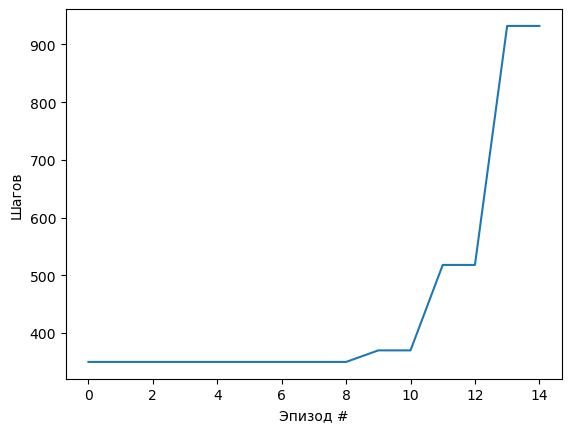

In [34]:

fig = plt.figure()
plt.plot(np.arange(ep), steps_ar)
plt.ylabel('Шагов')
plt.xlabel('Эпизод #')
plt.show()

Text(0.5, 1.0, 'Процентное разбиение причин завершения игры')

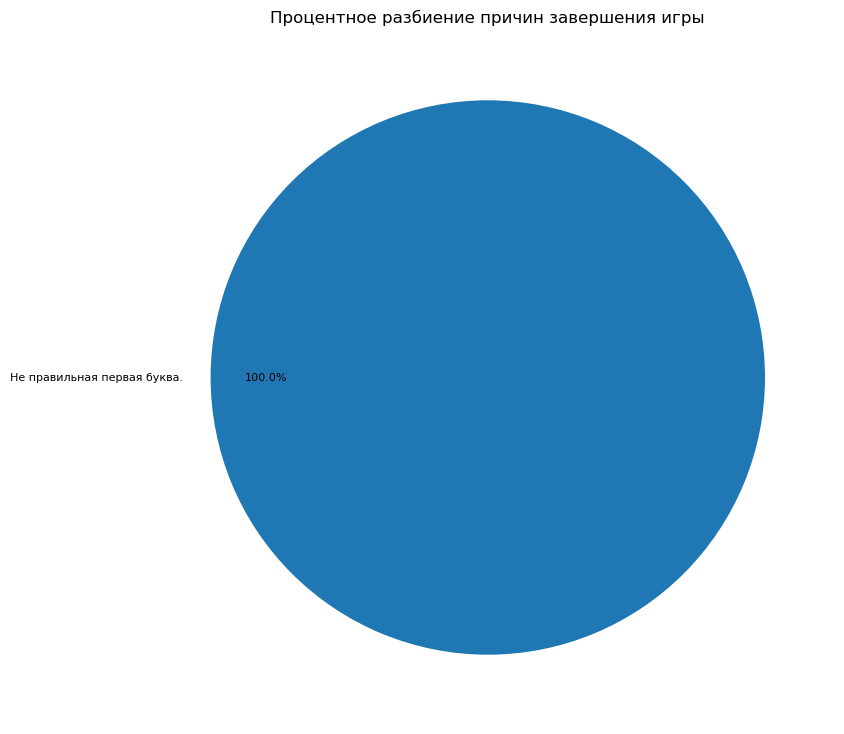

In [35]:
plt.figure(figsize =(12, 9))
pd.Series(inf_ar).value_counts().plot.pie(autopct='%1.1f%%',pctdistance=0.8, textprops={'fontsize': 8});
plt.title('Процентное разбиение причин завершения игры')

Text(0.5, 1.0, 'Последняя буква в игре')

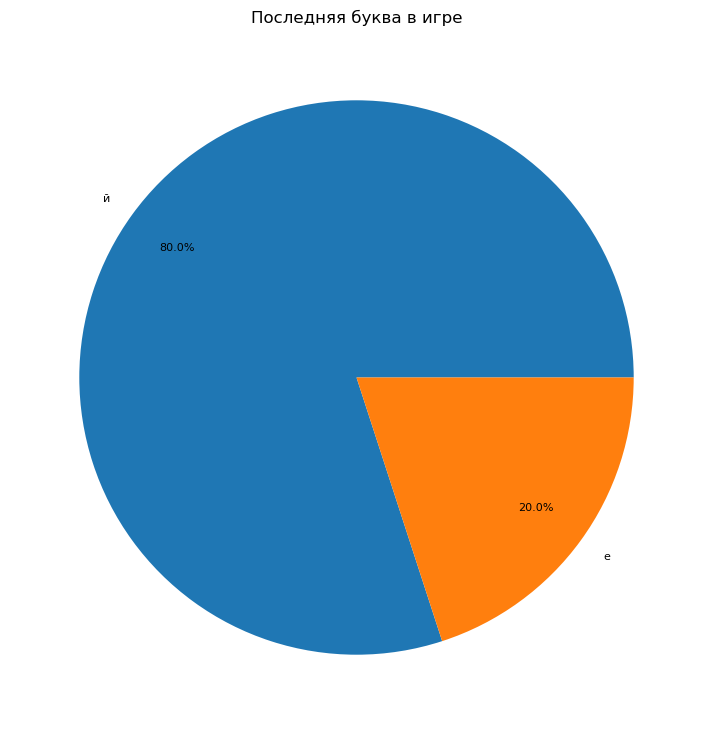

In [36]:
plt.figure(figsize =(12, 9))
pd.Series(last_let).value_counts().plot.pie(autopct='%1.1f%%',pctdistance=0.8, textprops={'fontsize': 8});
plt.title('Последняя буква в игре')

In [37]:
env.stat()[env.stat()['first']!=0]

,first,first_а,first_б,first_в,first_г,first_д,first_е,first_ж,first_з,first_и,...,last_ц,last_ч,last_ш,last_щ,last_э,last_ю,last_я,transf,last_let_av,no_city
5,100,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0.5,0.326586,-100
55,100,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0.5,0.266532,-100
81,100,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0.5,0.308637,-100
109,100,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0.5,0.294602,-100
137,100,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0.5,0.500000,-100
213,100,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0.5,0.392038,-100
241,100,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0.5,0.490688,-100
270,100,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0.5,0.002969,-100
298,100,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0.5,0.259514,-100
326,100,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0.5,0.140486,-100


In [38]:
env=Environment(cites[:sity_num], start_last)

agent = [Agent(state_size=stat_sz,action_size=start_last.shape[0], random_seed=10,bsize=env.stat().shape[0],MEM_SIZE=MEM_SIZE,LR_AC=LR_AC,SN_WEIGHT=SN_WEIGHT,dis_fuc=dis_fuc),#start_last.shape[0]),
         Agent(state_size=stat_sz,action_size=start_last.shape[0], random_seed=10,bsize=env.stat().shape[0],MEM_SIZE=MEM_SIZE,LR_AC=LR_AC,SN_WEIGHT=SN_WEIGHT,dis_fuc=dis_fuc)]#start_last.shape[0])]



steps_ar,cites_ar,inf_ar,agent,last_let=ddpg(ep)


Не правильная первая буква. Город: Уже использован Искомая буква й


Эпизод 0  Шаг завершения игры: 12 Количество городов начинающихся на искомую букву (в идеале = 0): 0 
Города:  Ахваз->Звенящий->Йингтан->Нинде->ЕСака->Александрия->Янтай->Йоханнесбург->Громче->Ереван->Ниамей->Уже использован
Не правильная первая буква. Город: Уже использован Искомая буква й


Эпизод 1  Шаг завершения игры: 12 Количество городов начинающихся на искомую букву (в идеале = 0): 0 
Города:  Ахваз->Звенящий->Йингтан->Нинде->ЕСака->Александрия->Янтай->Йоханнесбург->Громче->Ереван->Наказывающий->Уже использован
Не правильная первая буква. Город: Уже использован Искомая буква й


Эпизод 2  Шаг завершения игры: 12 Количество городов начинающихся на искомую букву (в идеале = 0): 0 
Города:  Ахваз->Звенящий->Йингтан->Нинде->ЕСака->Александрия->Янтай->Йоханнесбург->Громче->Ереван->Ниамей->Уже использован
Не правильная первая буква. Город: Уже использован Искомая буква й


Эпизод 3  Шаг завершения игры: 12 Количеств

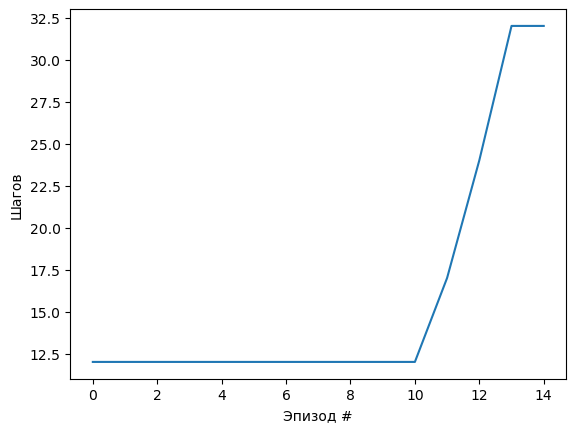

In [39]:
fig = plt.figure()
#ax = fig.add_subplot(111)
plt.plot(np.arange(ep), steps_ar)
plt.ylabel('Шагов')
plt.xlabel('Эпизод #')
plt.show()

In [40]:
env.stat()[env.stat()['first']!=0]

,first,first_а,first_б,first_в,first_г,first_д,first_е,first_ж,first_з,first_и,...,last_ц,last_ч,last_ш,last_щ,last_э,last_ю,last_я,transf,last_let_av,no_city
9,100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.5,0.432203,-100
85,100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.5,0.254237,-100
113,100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.5,0.228814,-100
141,100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.5,0.483051,-100
217,100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.5,0.398305,-100
245,100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.5,0.500000,-100
274,100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.5,0.118644,-100
302,100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.5,0.186441,-100
330,100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.5,0.067797,-100
358,100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.5,0.330508,-100
